# BIAS ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from IPython.display import display, clear_output

In [2]:
# Define the periods to analyze
periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']

In [3]:
# Load data for each period from CSV files
data = {}
for period in periods:
    data[period] = pd.read_csv(f"results/{period}_rf.csv")

NOTE: 

We trim the data at the 1% level each period before taking the average. Divide annual data by 4.

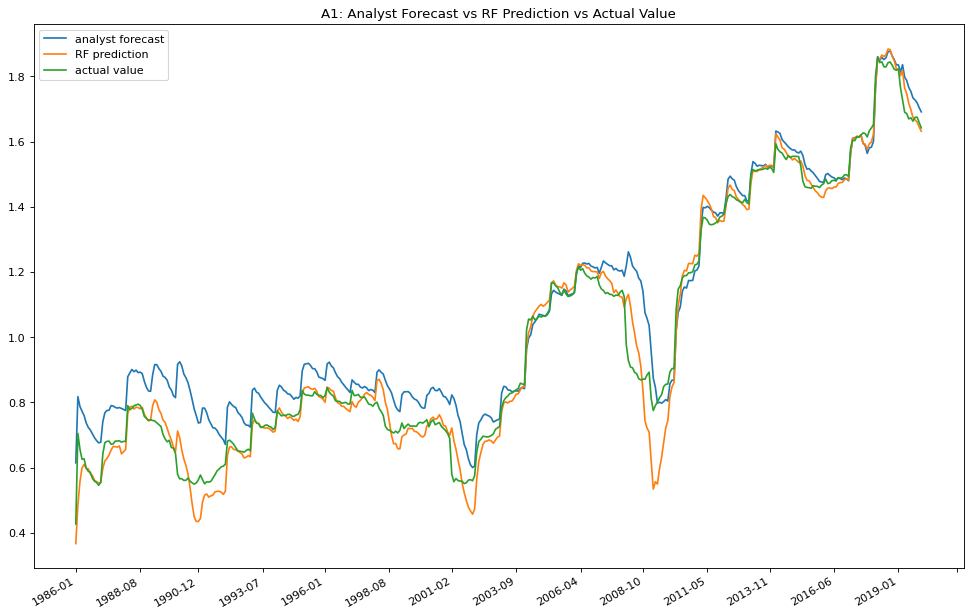

In [4]:
# Plot average forecasted and actual values for Q2
def plot_forecasts(df, period):
    plt.figure(figsize=(15, 10), dpi=80)
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).meanest.apply(lambda x: stats.trim_mean(x, 0.01)), label='analyst forecast')
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).predicted_adj_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label='RF prediction')
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).adj_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label='actual value')
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title(f'{period}: Analyst Forecast vs RF Prediction vs Actual Value')
    plt.savefig(f'images/{period}_RF_forecast_and_analyst_vs_actual.pdf', dpi=100, format='pdf')
    plt.show()

plot_forecasts(data['A1'], 'A1')

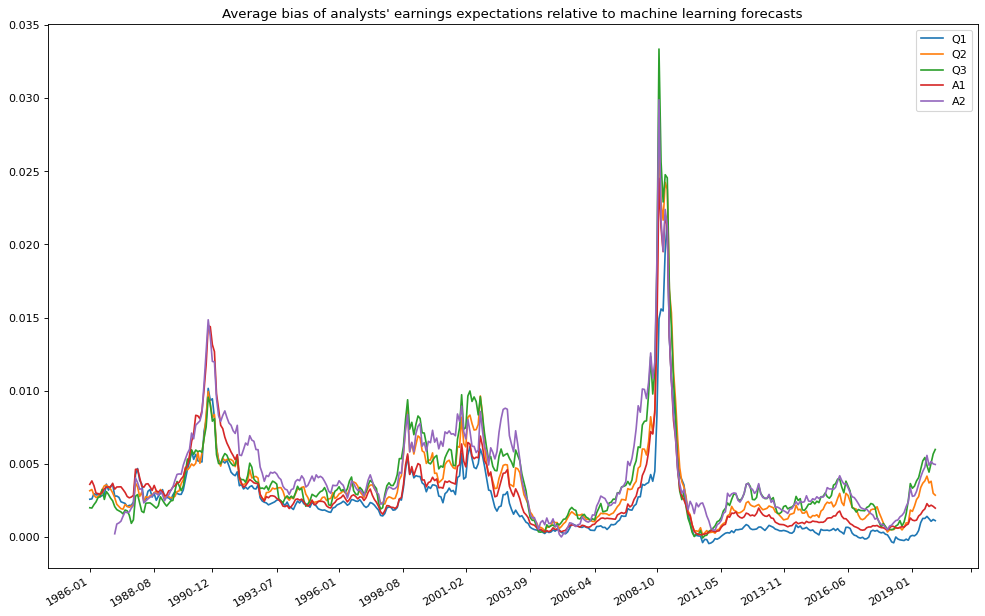

In [5]:
# Plot average bias of analysts' earnings expectations relative to machine learning forecasts for all periods
def plot_bias(data):
    plt.figure(figsize=(15, 10), dpi=80)
    for period, df in data.items():
        df_copy = df.copy()
        if period in ['A1', 'A2']:
            df_copy['bias_AF_ML'] = df_copy['bias_AF_ML'] / 4
        plt.plot(df_copy.Date.unique().astype(str), df_copy.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=period)
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Average bias of analysts\' earnings expectations relative to machine learning forecasts')
    plt.show()

plot_bias(data)

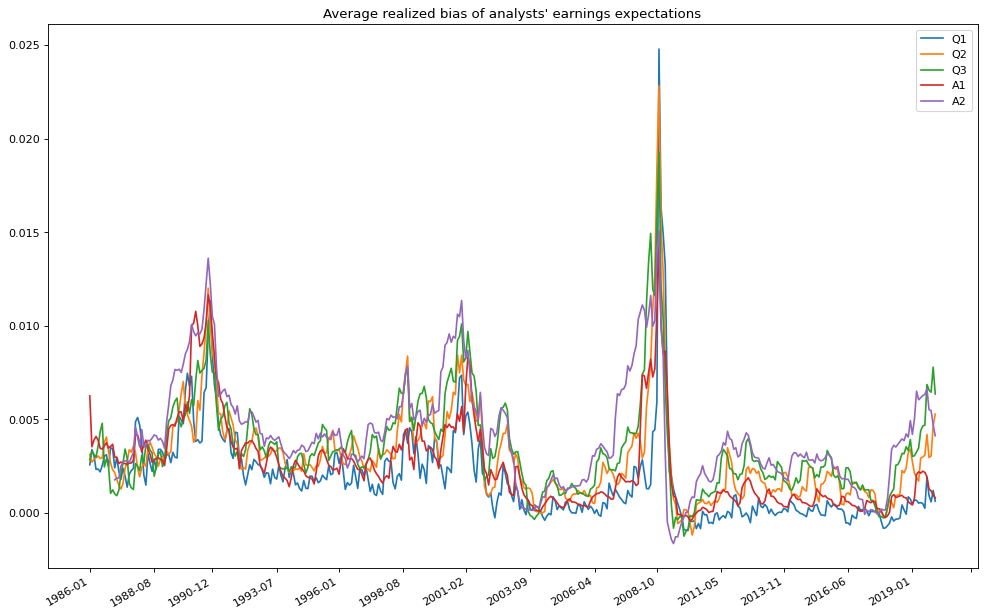

In [6]:
# Plot average realized bias of analysts' earnings expectations
def plot_realized_bias(data):
    plt.figure(figsize=(15, 10), dpi=80)
    for period, df in data.items():
        df['bias_analyst_actual'] = (df.meanest - df.adj_actual) / df.price
        if period in ['A1', 'A2']:
            df['bias_analyst_actual'] = df['bias_analyst_actual'] / 4
        plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=period)
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Average realized bias of analysts\' earnings expectations')
    plt.show()

plot_realized_bias(data)


## Bias wrt to machine learning model

In [7]:
# Compute bias results
def compute_bias_results(period, model):
    if model == 'RF':
        prediction = 'predicted_adj_actual'
    elif model == 'LR':
        prediction = 'predicted_adj_actual_LR'

    df = data[period]
    ML = df[prediction].mean()
    AF = df.meanest.mean()
    AE = df.adj_actual.mean()
    ML_AE = (df[prediction] - df.adj_actual).mean()
    AF_AE = (df.meanest - df.adj_actual).mean()
    ML_AE2 = ((df[prediction] - df.adj_actual) ** 2).mean()
    AF_AE2 = ((df.meanest - df.adj_actual) ** 2).mean()
    bias = ((df.meanest - df[prediction]) / df.price).mean()

    return {
        'value': period, 
        model: round(ML, 3), 
        'AF': round(AF, 3), 
        'AE': round(AE, 3),
        f'({model}-AE)': round(ML_AE, 3), 
        '(AF-AE)': round(AF_AE, 3),
        f'({model}-AE)^2': round(ML_AE2, 3), 
        '(AF-AE)^2': round(AF_AE2, 3), 
        f'(AF-{model})/P': round(bias, 3), 
        'N': len(df)
    }
    

These tables summarize the bias results for the Random Forest (RF) and Linear Regression (LR) models, including various metrics such as the mean predicted values, actual values, and the bias.

In [8]:
# Generate and display results
results_RF = [compute_bias_results(period, 'RF') for period in periods]
results_LR = [compute_bias_results(period, 'LR') for period in periods]

display(pd.DataFrame(results_RF).set_index('value').rename_axis(None))
display(pd.DataFrame(results_LR).set_index('value').rename_axis(None))

,RF,AF,AE,(RF-AE),(AF-AE),(RF-AE)^2,(AF-AE)^2,(AF-RF)/P,N
Q1,0.261,0.269,0.262,-0.002,0.007,0.031,0.030,0.003,874250
Q2,0.275,0.302,0.275,-0.000,0.027,0.042,0.044,0.004,768154
Q3,0.301,0.338,0.300,0.001,0.038,0.057,0.063,0.004,688193
A1,1.021,1.092,1.024,-0.004,0.067,0.341,0.354,0.014,860858
A2,1.324,1.497,1.313,0.011,0.184,1.034,1.283,0.019,661723


,LR,AF,AE,(LR-AE),(AF-AE),(LR-AE)^2,(AF-AE)^2,(AF-LR)/P,N
Q1,-4.126076e+05,0.269,0.262,-4.126079e+05,0.007,8.963050e+16,0.030,45221.986,874250
Q2,4.507256e+05,0.302,0.275,4.507253e+05,0.027,5.231619e+17,0.044,22983.450,768154
Q3,-7.676514e+05,0.338,0.300,-7.676517e+05,0.038,2.362580e+17,0.063,54547.555,688193
A1,-1.380587e+06,1.092,1.024,-1.380588e+06,0.067,3.354515e+18,0.354,45156.525,860858
A2,1.467996e+07,1.497,1.313,1.467996e+07,0.184,1.426021e+20,1.283,-967059.297,661723


# Explaining bias

## Bias and Number of Anlysts

These histograms show the distribution of the number of analysts per estimate across different periods.

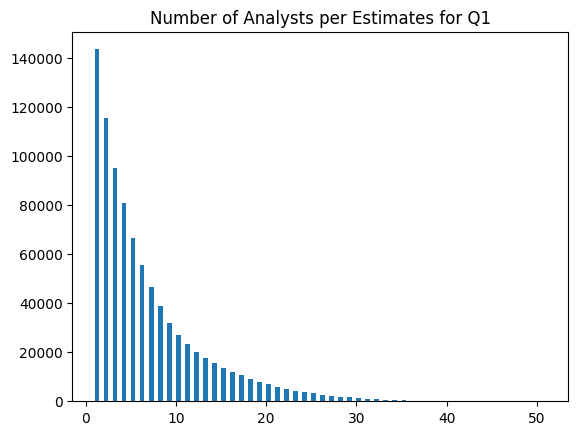

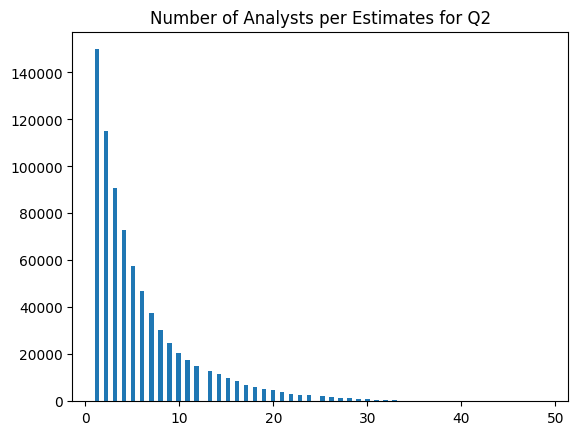

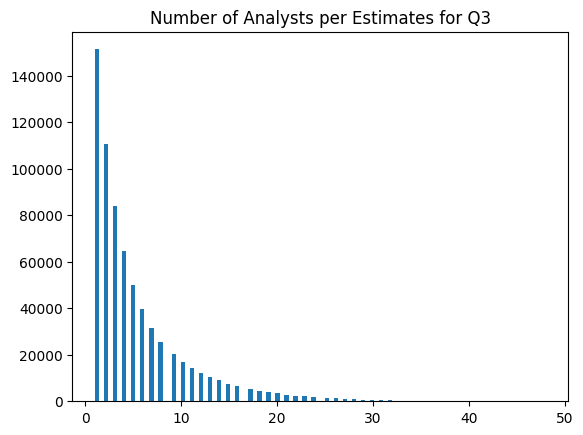

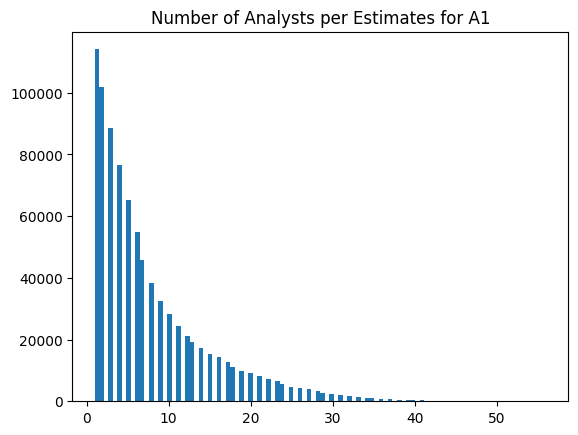

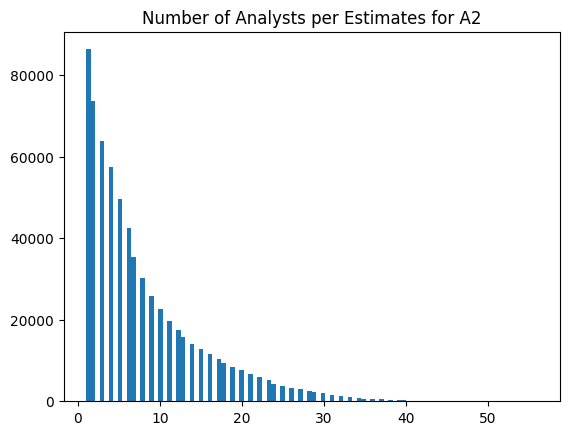

In [9]:
# Plot the number of analysts per estimates
def plot_num_analysts(data):
    for period in periods:
        plt.figure()
        df = data[period].copy()
        plt.hist(df.numest, bins=100)
        plt.title(f'Number of Analysts per Estimates for {period}')
        plt.show()

plot_num_analysts(data)

This scatter plot shows the average bias of analysts' earnings expectations relative to the machine learning forecasts, segmented by the number of analysts per estimate.

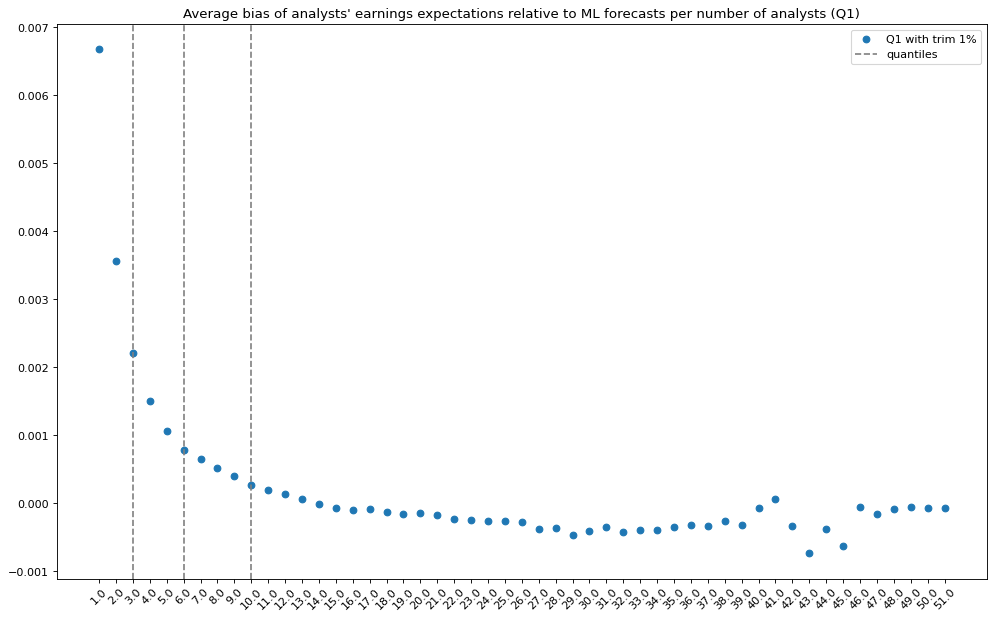

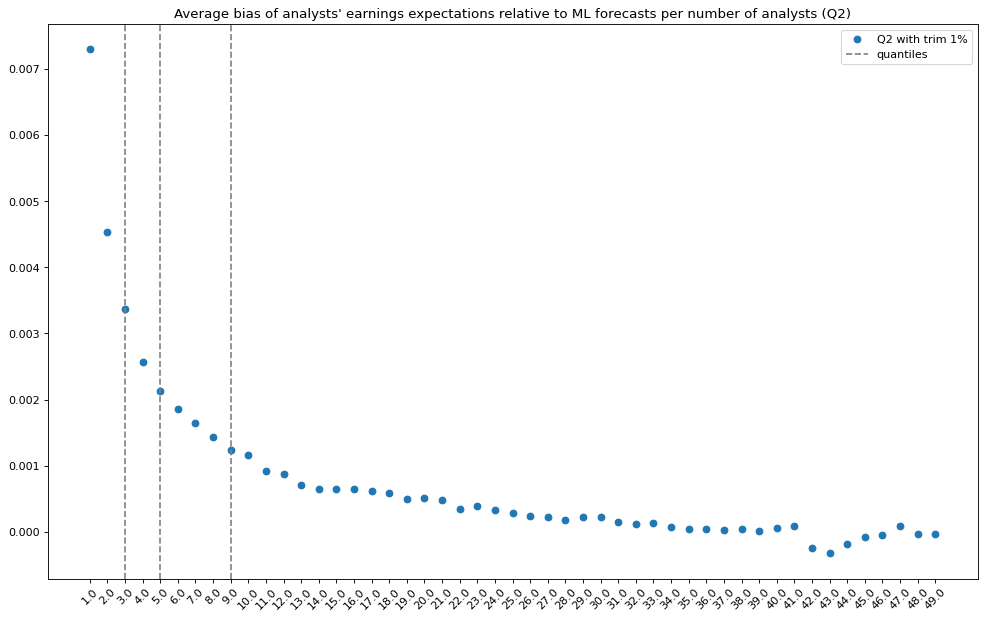

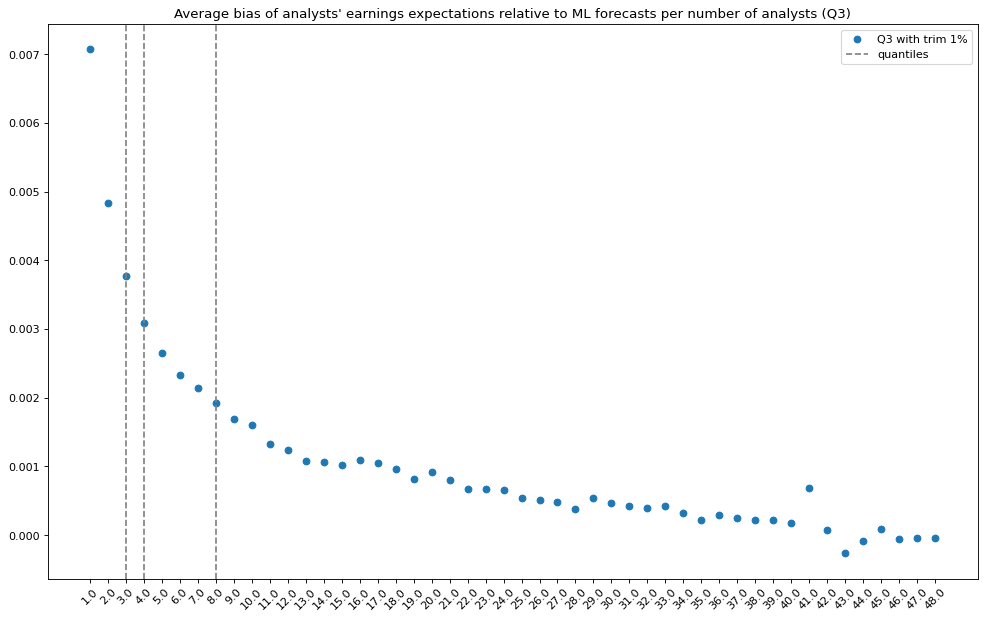

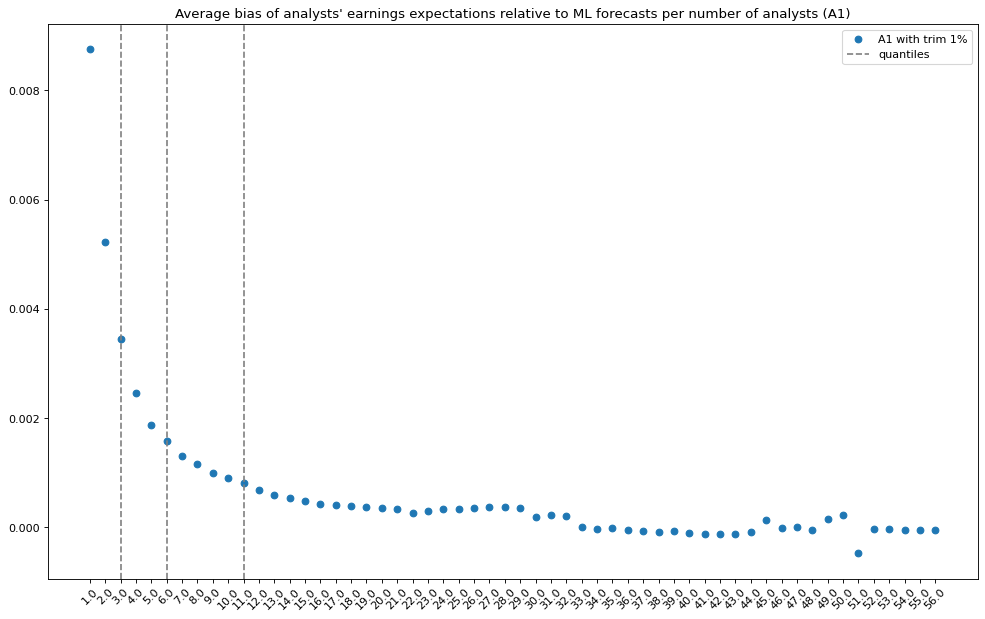

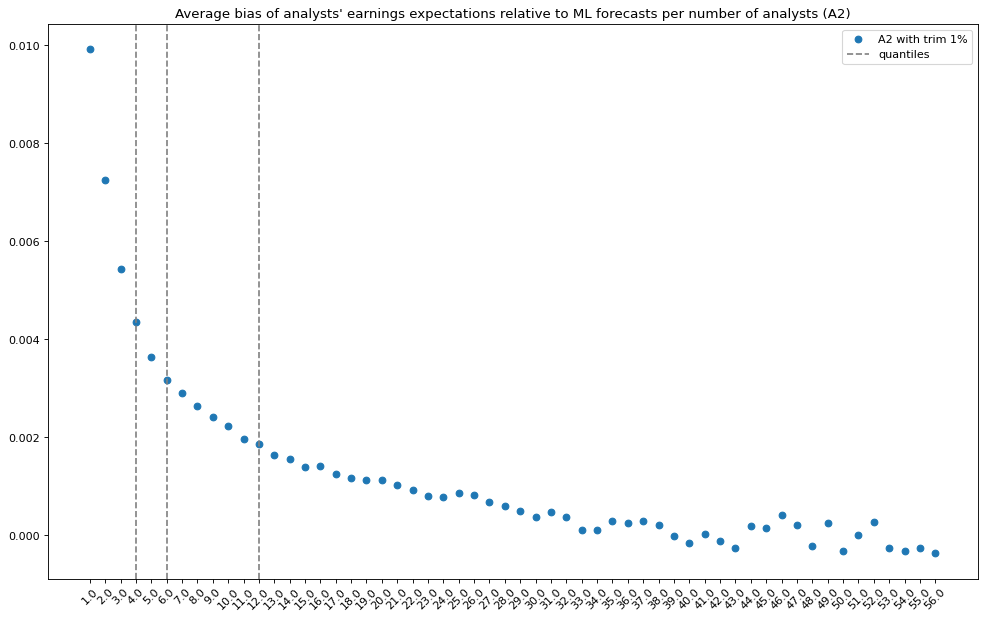

In [10]:
# Plot bias of analysts' earnings expectations relative to machine learning forecasts per number of analysts per estimates
def plot_bias_per_num_analysts(data):
    for period in periods:
        plt.figure(figsize=(15, 9), dpi=80)
        df = data[period].copy()
        df.sort_values('numest', inplace=True)
        if period in ['A1', 'A2']:
            df['bias_AF_ML'] = df['bias_AF_ML'] / 4
        plt.scatter(df.numest.unique().astype(str), df.groupby(['numest']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period} with trim 1%')
        plt.axvline(df.numest.quantile(0.25), color='grey', linestyle='--', label='quantiles')
        plt.axvline(df.numest.quantile(0.5), color='grey', linestyle='--')
        plt.axvline(df.numest.quantile(0.75), color='grey', linestyle='--')
        plt.xticks(rotation=45)
        plt.legend()
        plt.title(f'Average bias of analysts\' earnings expectations relative to ML forecasts per number of analysts ({period})')
        plt.show()

plot_bias_per_num_analysts(data)

#### We focus on A1 and A2 forecats horizons

In [11]:
df_1 = pd.read_csv(f"results/A1_rf.csv")
df_2 = pd.read_csv(f"results/A2_rf.csv")
dictionary = {'A1': df_1, 'A2': df_2}


This analysis provides time series plots of the bias for different quantiles of the number of analysts, both relative to actual values and ML forecasts.

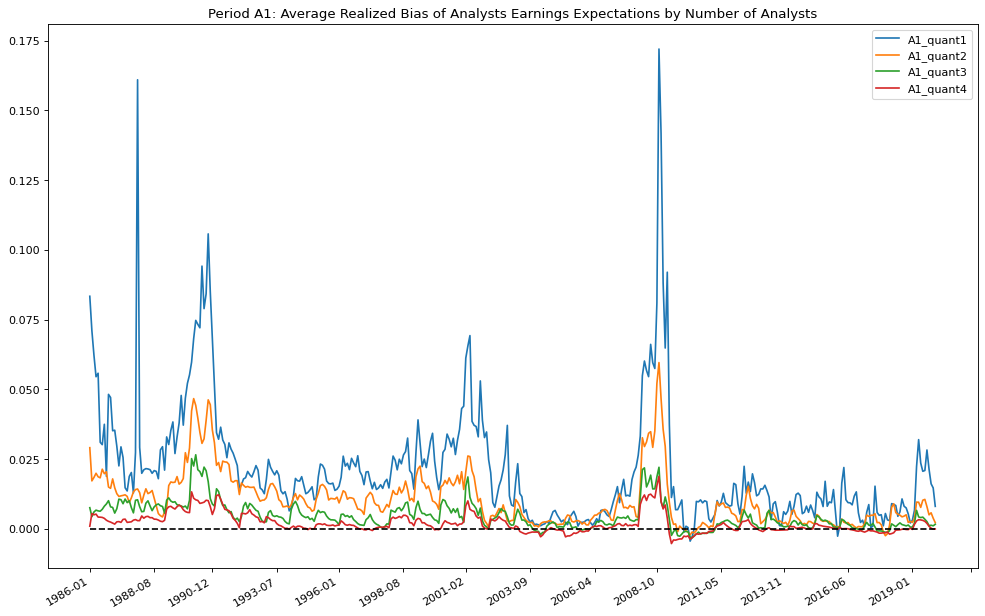

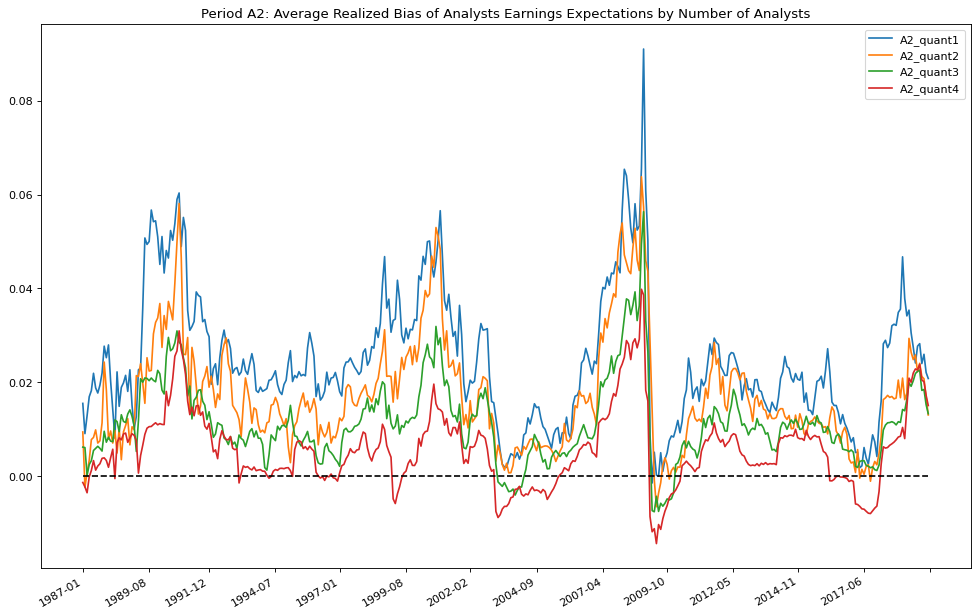

In [12]:
#Bias with Respect to Actual Value
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df['bias_AF_AE'] = (df.meanest - df.adj_actual) / df.price
    for quantile, label in zip([0.25, 0.5, 0.75, 1], ['_quant1', '_quant2', '_quant3', '_quant4']):
        df_trunc = df[(df.numest > df.numest.quantile(quantile - 0.25)) & (df.numest <= df.numest.quantile(quantile))]
        plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}{label}')
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()
    plt.title(f'Period {period}: Average Realized Bias of Analysts Earnings Expectations by Number of Analysts')
    plt.show()


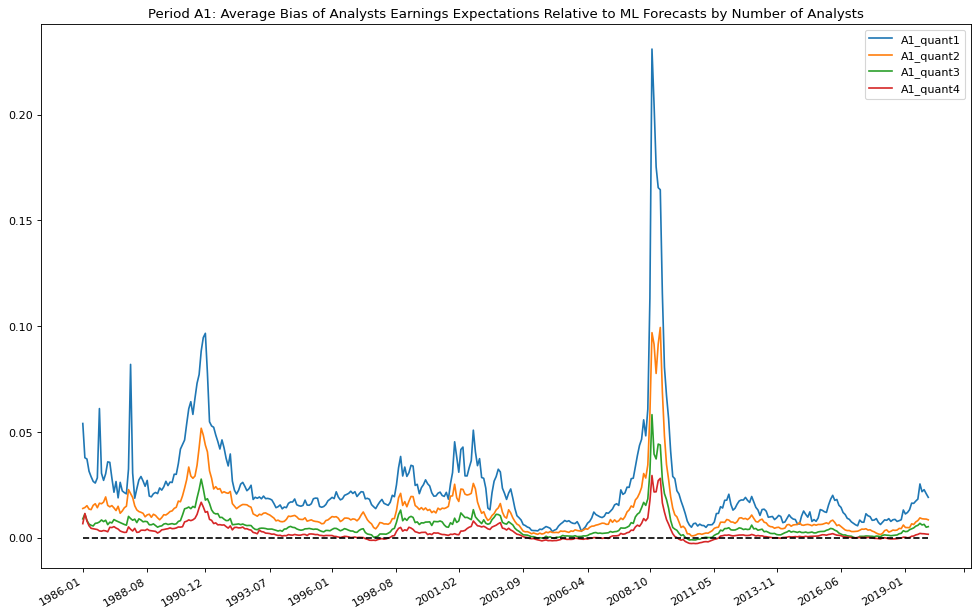

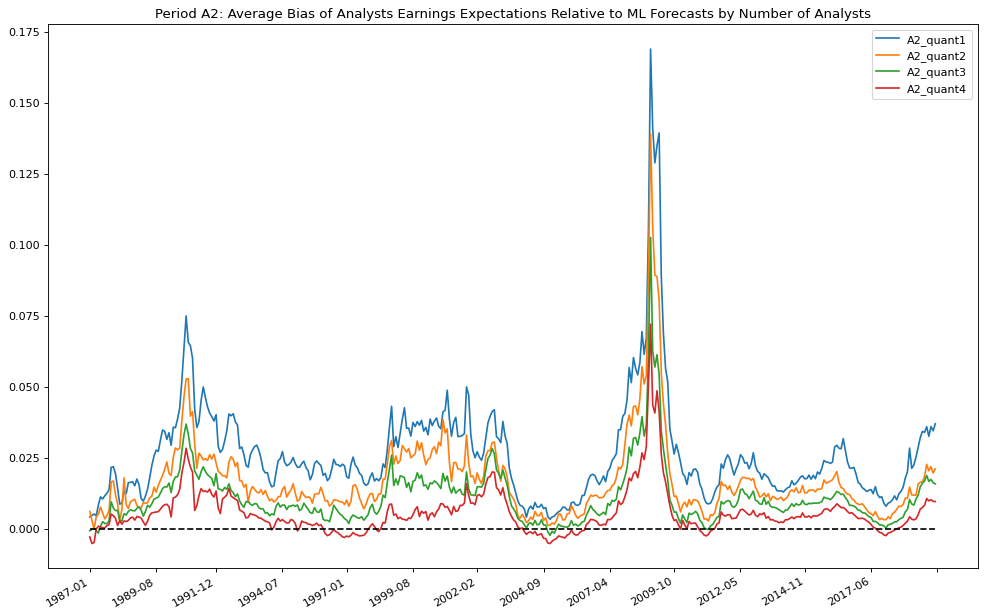

In [13]:
# Bias Relative to ML Forecasts

for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    for quantile, label in zip([0.25, 0.5, 0.75, 1], ['_quant1', '_quant2', '_quant3', '_quant4']):
        df_trunc = df[(df.numest > df.numest.quantile(quantile - 0.25)) & (df.numest <= df.numest.quantile(quantile))]
        plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}{label}')
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()
    plt.title(f'Period {period}: Average Bias of Analysts Earnings Expectations Relative to ML Forecasts by Number of Analysts')
    plt.show()

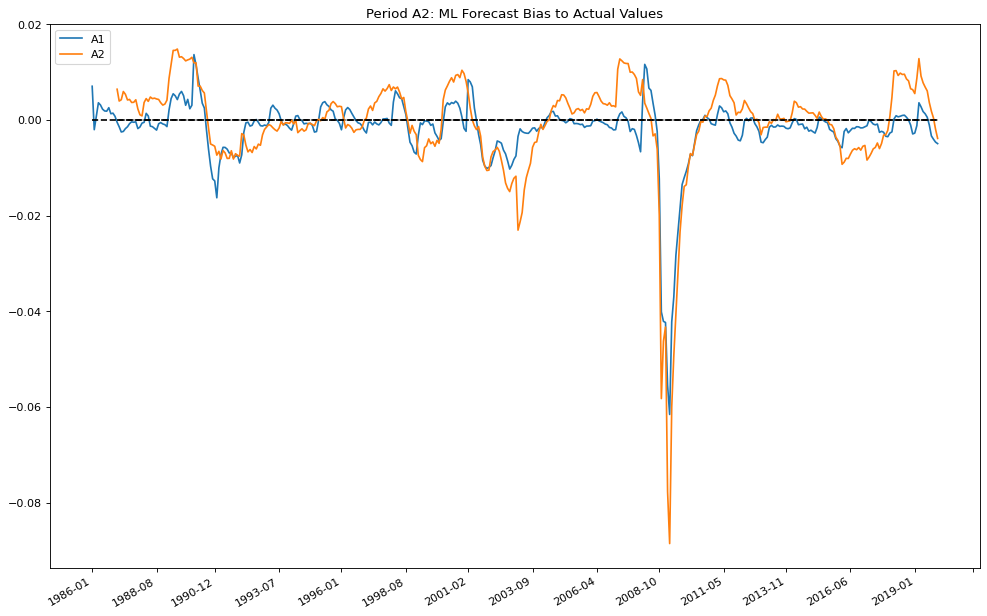

In [14]:
# ML Forecast Bias to Actual Values

plt.figure(figsize=(15, 10), dpi=80)
for period, df in dictionary.items():
    df['bias_ML_AE'] = (df.predicted_adj_actual - df.adj_actual) / df.price
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_ML_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}')
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df.Date.unique().astype(str)), max(df.Date.unique().astype(str)), 'black', linestyles='dashed')
plt.legend()
plt.title(f'Period {period}: ML Forecast Bias to Actual Values')
plt.show()

## Regulation Impact Analysis - Reg FD, November 2000

To analyze the impact of regulations on analysts' forecasts, we need to consider specific regulatory events and periods. For instance, the Regulation Fair Disclosure (Reg FD) introduced in end October 2000 in the US aimed at preventing selective disclosure by companies, which might have had an impact on analysts' forecasting behavior.

We will analyze the bias of analysts' forecasts relative to the actual values and ML forecasts for both the pre-regulation and post-regulation periods.

In [15]:
def compute_bias_results(period):
    df = data[period]
    df_pre = df[df.Date <= '2000-10']
    df_post = df[df.Date > '2000-10']
    bias_analyst_ml_pre = df_pre.bias_AF_ML.mean()
    bias_analyst_actual_pre = ((df_pre.meanest - df_pre.adj_actual) / df_pre.price).mean()
    bias_analyst_ml_post = df_post.bias_AF_ML.mean()
    bias_analyst_actual_post = ((df_post.meanest - df_post.adj_actual) / df_post.price).mean()

    return {'value': period,
            'Bias AF-AE pre 2000': round(bias_analyst_actual_pre, 3),
            'Bias AF-AE post 2000': round(bias_analyst_actual_post, 3),
            'Bias AF-RF value pre 2000': round(bias_analyst_ml_pre, 3),
            'Bias AF-RF post 2000': round(bias_analyst_ml_post, 3),
            'N pre 2000': len(df_pre),
            'N post 2000': len(df_post)}

In [16]:
# Create an empty list to store results
results = []

# Compute bias results for periods A1 and A2
for period in ['A1', 'A2']:
    results.append(compute_bias_results(period))

# Display results as DataFrame
display(pd.DataFrame(results).set_index('value').rename_axis(None))

,Bias AF-AE pre 2000,Bias AF-AE post 2000,Bias AF-RF value pre 2000,Bias AF-RF post 2000,N pre 2000,N post 2000
A1,0.021,0.011,0.017,0.012,353520,507338
A2,0.024,0.015,0.022,0.017,238835,422888


In [17]:
# Create a new column to mark pre-regulation period
data['A1']['pre_regulation'] = np.where(data['A1'].Date <= '2000-10', 1, 0)
data['A2']['pre_regulation'] = np.where(data['A2'].Date <= '2000-10', 1, 0)

# Describe bias_AF_ML for pre and post regulation groups in A1 and A2
for dataset in ['A1', 'A2']:
    display(data[dataset].groupby("pre_regulation")['bias_AF_ML'].describe())


,count,mean,std,min,25%,50%,75%,max
pre_regulation,,,,,,,,
0,507338.0,0.011947,0.089846,-6.794787,-0.000770,0.001089,0.007275,24.917599
1,353520.0,0.017077,0.067030,-4.920289,-0.000205,0.003633,0.015513,10.850041


,count,mean,std,min,25%,50%,75%,max
pre_regulation,,,,,,,,
0,422888.0,0.017354,0.056684,-1.981208,-0.000628,0.005679,0.019277,8.583972
1,238835.0,0.021820,0.051764,-2.238527,-0.003757,0.008135,0.031975,2.564030


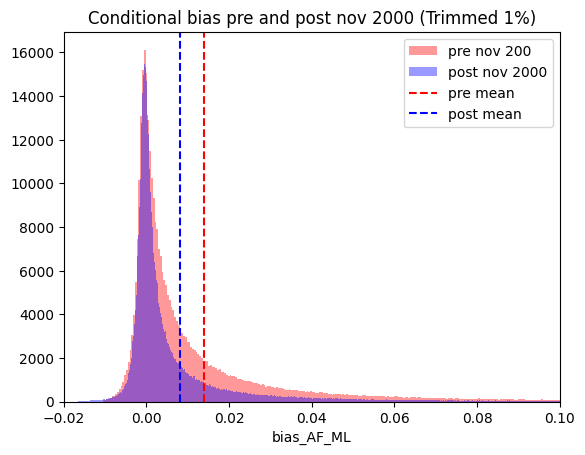

In [18]:
# Create filters for pre and post regulation groups in A1
pre_regulation_A1 = data['A1'][data['A1']['pre_regulation'] == 1]['bias_AF_ML']
post_regulation_A1 = data['A1'][data['A1']['pre_regulation'] == 0]['bias_AF_ML']

# Trim data for each group (trimming 1% from both ends)
trim_percent = 1
lower_percentile_A1 = np.percentile(pre_regulation_A1, trim_percent)
upper_percentile_A1 = np.percentile(pre_regulation_A1, 100 - trim_percent)
trimmed_pre_regulation_A1 = pre_regulation_A1[(pre_regulation_A1 >= lower_percentile_A1) & (pre_regulation_A1 <= upper_percentile_A1)]

lower_percentile_post = np.percentile(post_regulation_A1, trim_percent)
upper_percentile_post = np.percentile(post_regulation_A1, 100 - trim_percent)
trimmed_post_regulation_A1 = post_regulation_A1[(post_regulation_A1 >= lower_percentile_post) & (post_regulation_A1 <= upper_percentile_post)]

# Plot histograms for pre and post regulation groups in A1
plt.hist(trimmed_pre_regulation_A1, alpha=0.4, bins='auto', color='red', label='pre nov 200')
plt.hist(trimmed_post_regulation_A1, alpha=0.4, bins='auto', color='blue', label='post nov 2000')

# Plot mean lines for pre and post regulation groups in A1
plt.axvline(trimmed_pre_regulation_A1.mean(), color='red', linestyle='--', label='pre mean')
plt.axvline(trimmed_post_regulation_A1.mean(), color='blue', linestyle='--', label='post mean')

plt.legend()
plt.xlabel('bias_AF_ML')
plt.title('Conditional bias pre and post nov 2000 (Trimmed 1%)')
plt.xlim(-0.02, 0.10)
plt.show()

## Bias and Error

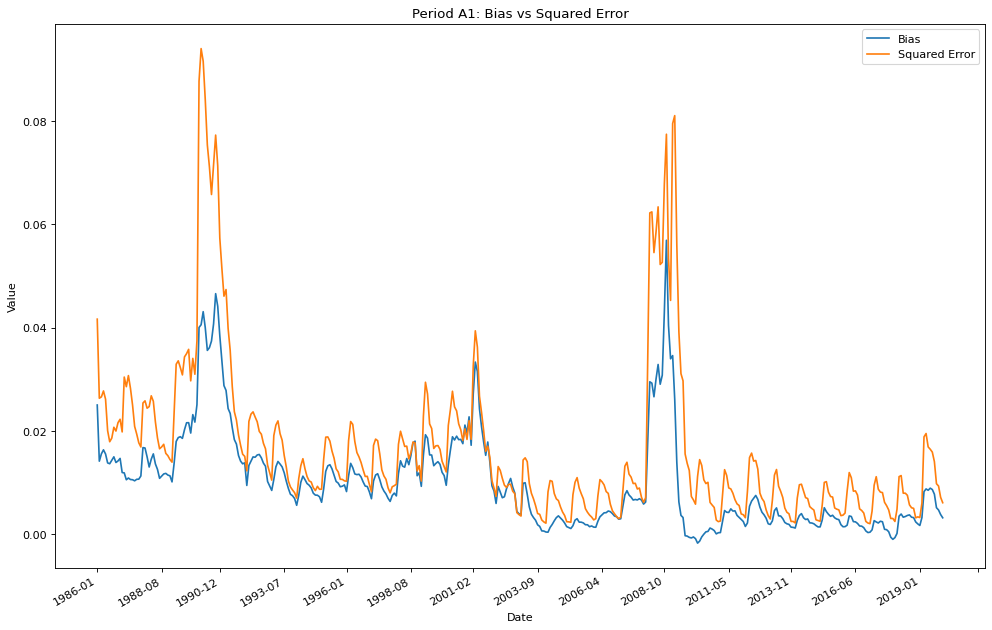

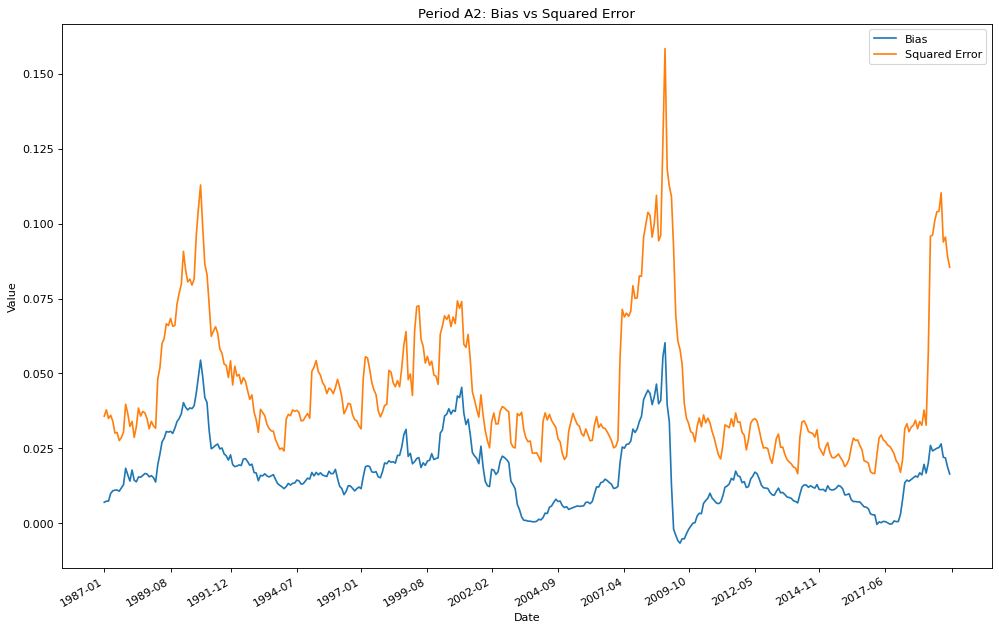

In [19]:
for period, df in dictionary.items():
    # Create a new figure
    plt.figure(figsize=(15, 10), dpi=80)
    
    # Calculate bias: (meanest - adj_actual) / price
    df['bias_analyst_actual'] = (df['meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error: ((meanest - adj_actual) ** 2) / price
    df['squared_error'] = ((df['meanest'] - df['adj_actual']) ** 2) / df['price']
    
    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                         'squared_error': lambda x: stats.trim_mean(x, 0.01)})
    
    # Plot bias against squared error
    plt.plot(df_grouped.index.astype(str), df_grouped['bias_analyst_actual'], label='Bias')
    plt.plot(df_grouped.index.astype(str), df_grouped['squared_error'], label='Squared Error')
    
    # Set x-axis to display months and rotate labels
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    
    # Add legend and title
    plt.legend()
    plt.title(f'Period {period}: Bias vs Squared Error')
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    plt.show()